In [1]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt
from time import sleep

(a) Generate a random symmetric matrix and generate groundtruth eigenvalues and eigenvectors

In [2]:
A = np.random.normal(size=(10,10))
A = (A+A.transpose())/2

In [3]:
true_evals,true_evecs=linalg.eig(A)
big_eval = true_evals[0]
big_evec = true_evecs[:,0]
true_evals

array([ 3.92047789+0.j, -3.44155   +0.j,  3.0062582 +0.j,  2.24338797+0.j,
       -2.47583614+0.j, -1.94097189+0.j,  0.90320472+0.j, -0.33484138+0.j,
       -0.82849269+0.j,  0.20911811+0.j])

(b) Find the largest eigenvalue by power iteration

In [4]:
def power_iter(A,thresh=1e-5,n=None,true_eval=None):
    v_old = np.zeros(A.shape[1],dtype=np.complex128)
    v_old[0]=1j
    val_old = v_old.transpose() @ A @ v_old
    
    w = A@v_old
    v_new = w/np.sqrt(np.sum(w**2))
    val_new = v_new.transpose() @ A @ v_new
    
    diff = np.abs(val_old - val_new)
    if true_eval is not None:
        err = np.abs(val_new - true_eval)
        err_L = [err]
    
    if n is not None:
        for i in range(n):
            v_old = v_new
            val_old = val_new

            w = A@v_old
            v_new = w/np.sqrt(np.sum(w**2))
            val_new = v_new.transpose() @ A @ v_new
            if true_eval is not None:
                err = np.abs(val_new-true_eval)
                err_L += [err]
        return ((val_new,v_new) if true_eval is None else (val_new,v_new,err_L))
    
    else:
        while diff > thresh:
            v_old = v_new
            val_old = val_new

            w = A@v_old
            v_new = w/np.sqrt(np.sum(w**2))
            val_new = v_new.transpose() @ A @ v_new

            diff = np.abs(val_old - val_new)
            if true_eval is not None:
                err = np.abs(val_new-true_eval)
                err_L += [err]
        return ((val_new,v_new) if true_eval is None else (val_new,v_new,err_L))

In [5]:
eigval,eigvec,err_L = power_iter(A,true_eval=big_eval)
eigval

(3.920448587786472+0j)

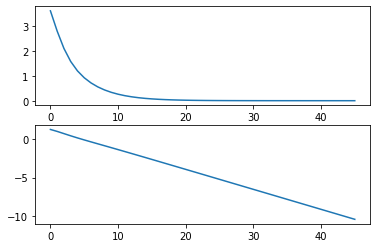

In [6]:
plt.subplot(211)
plt.plot(err_L)
plt.subplot(212)
plt.plot(np.log(err_L))

Unsurprisingly, the error is exponentially decreasing.

In [7]:
def rayleigh_iter(A,mu,thresh=1e-5):
    M = A - mu*np.eye(A.shape[0])
    
    v_old = np.zeros(10,dtype=np.complex128)
    v_old[0]=1j
    val_old = v_old.transpose() @ A @ v_old
    
    w = linalg.solve(M,v_old)
    v_new = w/np.sqrt(np.sum(w**2))
    val_new = v_new.transpose() @ A @ v_new
    
    diff = np.abs(val_old - val_new)
    
    while diff > thresh:
        v_old = v_new
        val_old = val_new

        w = linalg.solve(M,v_old)
        v_new = w/np.sqrt(np.sum(w**2))
        val_new = v_new.transpose() @ A @ v_new

        diff = np.abs(val_old - val_new)
    
    return (val_new,v_new)

def rayleigh_iter_binary_search(A,bounds,thresh=1e-5,eps=-1e-5):
    sleep(0.1)
    
    # Return all eigenvalues inside bounds and ignore everything outside
    mu = (bounds[0]+bounds[1])/2
    val,vec=rayleigh_iter(A,mu,thresh)
    
    if val < bounds[0] or val > bounds[1]:
        return [],[]
    else:
        ruled_out = [val + eps,2*mu-val-eps] if val < mu else [2*mu-val+eps,val-eps]
        L_bounds = [bounds[0],ruled_out[0]]
        R_bounds = [ruled_out[1],bounds[1]]
        
        L_vals,L_vecs = rayleigh_iter_binary_search(A,L_bounds,thresh,eps)
        R_vals,R_vecs = rayleigh_iter_binary_search(A,R_bounds,thresh,eps)
        return L_vals + [val] + R_vals, L_vecs + [vec] + R_vecs
        
def rayleigh_iter_all(A,thresh=1e-5,eps=-1e-10,factor=2):
    
    # First we find the eigenvalue closest to 0
    mu = 0
    val,vec = rayleigh_iter(A,mu,thresh)
    vals,vecs = [val],[vec]
    
    # the eigenvalues of symmetric matrices are real so we only need search the real line
    # we can rule out anything closer to mu than val, but with some error, so we shrink bounds
    bounds = [val+eps,2*mu-val-eps] if val < mu else [2*mu - val+eps, val-eps]
    
    lower = True
    while len(vals) < A.shape[0]:
        
        if lower:
            # search the lower bounds
            mu = factor*bounds[0]
            val,vec = rayleigh_iter(A,mu,thresh)

            if val > bounds[0]:
                bounds[0] = 2*factor*bounds[0] - val
            else:
                vals += [val]
                vecs += [vec]

                # now we've ruled out (mu +- (mu-val)) but we have a gap that we must search
                mu_lower,mu_upper = (val+eps,2*mu-val-eps) if val < mu else (2*mu-val+eps,val-eps)
                gap_vals,gap_vecs = rayleigh_iter_binary_search(A,[mu_upper,bounds[0]],thresh,eps)
                vals += gap_vals
                vecs += gap_vecs

                bounds[0] = mu_lower
                
            lower=False
            
        else:
            # search the upper bounds
            mu = factor*bounds[1]
            val,vec = rayleigh_iter(A,mu,thresh)

            if val < bounds[1]:
                bounds[1] = 2*factor*bounds[1] - val
            else:
                vals += [val]
                vecs += [vec]

                # now we've ruled out (mu +- (mu-val)) but we have a gap that we must search
                mu_lower,mu_upper = (val+eps,2*mu-val-eps) if val < mu else (2*mu-val+eps,val-eps)
                gap_vals,gap_vecs = rayleigh_iter_binary_search(A,[bounds[1],mu_lower],thresh,eps)
                vals += gap_vals
                vecs += gap_vecs

                bounds[1] = mu_upper
                
            lower=True
    return vals,vecs

In [10]:
vals,vecs = rayleigh_iter_all(A)
vals2,vecs2 = rayleigh_iter_binary_search(A,[-np.abs(2*eigval),np.abs(2*eigval)])

In [12]:
print(np.sort(vals))
print(np.sort(vals2))

print(np.sort(true_evals))

[-0.82849216+0.j -0.82849183+0.j -0.33484159+0.j -0.33484138+0.j
 -0.33484137+0.j  0.20911472+0.j  0.20911811+0.j  0.20911863+0.j
  0.90320467+0.j  0.90320472+0.j  0.90320508+0.j]
[-3.44154938+0.j -2.47583704+0.j -2.4659099 +0.j -1.94097191+0.j
 -0.82849266+0.j -0.33484359+0.j  0.20911472+0.j  0.85991558+0.j
  0.90320472+0.j  2.24338803+0.j  2.72114401+0.j  3.00625821+0.j
  3.92047789+0.j]
[-3.44155   +0.j -2.47583614+0.j -1.94097189+0.j -0.82849269+0.j
 -0.33484138+0.j  0.20911811+0.j  0.90320472+0.j  2.24338797+0.j
  3.0062582 +0.j  3.92047789+0.j]


This method is reasonably successful in finding all the eigenvalues and eigenvectors automatically, but struggles to handle both false negatives and false positives. That is, it struggles to avoid throwing out one of a pair of eigenvalues which are very similar to one another while simultaneously avioding duplication of eigenvalues.

TODO: compare accuracy as a function of iterations and discuss initial guesses

(d) This is substantially more complicated since we can no longer rely on a binary search algorithm to efficiently search the parameter space.

In [13]:
A = np.random.normal(size=(10,10))

In [18]:
true_evals,true_evecs=linalg.eig(A)
big_eval = true_evals[0]
big_evec = true_evecs[:,0]
true_evals

array([-2.00021795+1.41092489j, -2.00021795-1.41092489j,
       -2.1763106 +0.j        ,  4.00927635+0.j        ,
       -0.35106744+1.82421838j, -0.35106744-1.82421838j,
        2.82032423+0.j        ,  1.77527483+0.j        ,
        1.16009031+1.15564961j,  1.16009031-1.15564961j])

In [35]:
eigval,eigvec = power_iter(A,)
biggest_eval = eigval

Now let's choose 10 different values of $\mu$ as multiples of complex units.

In [38]:
angles = np.linspace(0,2*np.pi,10,endpoint=False)
mus = biggest_eval*np.exp(1j*angles)/2
mus

array([ 2.00464822+0.00000000e+00j,  1.62179447+1.17830266e+00j,
        0.61947037+1.90653375e+00j, -0.61947037+1.90653375e+00j,
       -1.62179447+1.17830266e+00j, -2.00464822+2.45498602e-16j,
       -1.62179447-1.17830266e+00j, -0.61947037-1.90653375e+00j,
        0.61947037-1.90653375e+00j,  1.62179447-1.17830266e+00j])

[-2.17631142-7.90676179e-21j -2.00021661-1.41092377e+00j
 -2.00021661+1.41092377e+00j -0.35106675+1.82421790e+00j
 -0.35106675-1.82421790e+00j  1.16009139-1.15565076e+00j
  1.16009139+1.15565076e+00j  1.16009275+1.15565444e+00j
  1.16009275-1.15565444e+00j  1.77527592+0.00000000e+00j]
[-2.1763106 +0.j         -2.00021795-1.41092489j -2.00021795+1.41092489j
 -0.35106744-1.82421838j -0.35106744+1.82421838j  1.16009031-1.15564961j
  1.16009031+1.15564961j  1.77527483+0.j          2.82032423+0.j
  4.00927635+0.j        ]


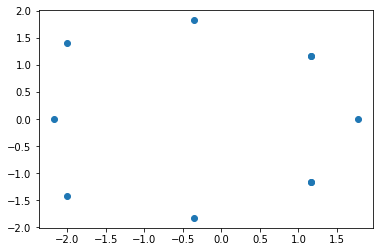

In [59]:
evals,evecs = [],[]
for mu in mus:
    ev,evec = rayleigh_iter(A,mu)
    evals += [ev]
    evecs += [evec]
print(np.sort(evals))
print(np.sort(true_evals))
plt.plot(np.real(evals),np.imag(evals),"o")

We still have a few duplicates and are missing the largest eigenvalue.

Problem 2

In [60]:
from PIL import Image
from os import listdir
from matplotlib import image

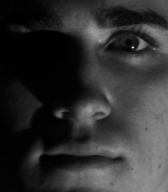

In [62]:
people = ["data/CroppedYale/{p}".format(p=person) for person in listdir("data/CroppedYale")]
shots = ["{p}/{s}".format(p=person,s=shot) for person in people for shot in listdir(person)]
images = [Image.open(shot) for shot in shots]
images[0]

In [63]:
data = [np.asarray(image) for image in images]
flat_data = np.array([d.flatten() for d in data])
flat_data.shape

(2432, 32256)

In [64]:
def power_iter_nonsquare(A,thresh=1e-5,n=None,true_eval=None):
    v_old = np.zeros(A.shape[1])
    v_old[0]=1
    Av_old = A @ v_old
    val_old = np.sqrt(np.sum(Av_old**2))
    
    w = A.transpose()@(A@v_old)
    v_new = w/np.sqrt(np.sum(w**2))
    Av_new = A @ v_new
    val_new = np.sqrt(np.sum(Av_new**2))
    
    diff = np.abs(val_old - val_new)
    if true_eval is not None:
        err = np.abs(val_new - true_eval)
        err_L = [err]
    
    if n is not None:
        for i in range(n):
            v_old = v_new
            val_old = val_new

            w = A.transpose()@(A@v_old)
            v_new = w/np.sqrt(np.sum(w**2))
            Av_new = A @ v_new
            val_new = np.sqrt(np.sum(Av_new**2))
            if true_eval is not None:
                err = np.abs(val_new-true_eval)
                err_L += [err]
        return ((val_new,v_new) if true_eval is None else (val_new,v_new,err_L))
    
    else:
        while diff > thresh:
            v_old = v_new
            val_old = val_new

            w = A.transpose()@(A@v_old)
            v_new = w/np.sqrt(np.sum(w**2))
            Av_new = A @ v_new
            val_new = np.sqrt(np.sum(Av_new**2))

            diff = np.abs(val_old - val_new)
            if true_eval is not None:
                err = np.abs(val_new-true_eval)
                err_L += [err]
        return ((val_new,v_new) if true_eval is None else (val_new,v_new,err_L))

In [65]:
eigval,eigvec = power_iter_nonsquare(flat_data)
print(eigval)

700713.6688011991


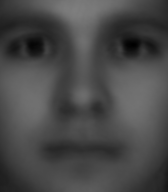

In [66]:
eig_image = np.reshape(127*(eigvec-np.min(eigvec))/(np.max(eigvec)-np.min(eigvec)),data[0].shape)
eig_image = Image.fromarray(eig_image.astype(np.uint8))
eig_image

CPU times: user 1min 22s, sys: 2.47 s, total: 1min 24s
Wall time: 14.8 s
[0.11175691 0.05076492 0.02109159 0.01816213 0.01055308 0.01028901
 0.00890934 0.008343   0.00742993 0.00736778]
700713.6


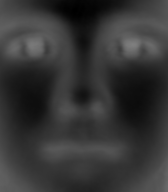

In [67]:
%time U,S,Vh = linalg.svd(flat_data,full_matrices=False)
print(S[0:10]/np.sum(S))
print(S[0])
leading_mode = np.reshape(127*(Vh[0,:]-np.min(Vh[0,:]))/(np.max(Vh[0,:])-np.min(Vh[0,:])),data[0].shape)
leading_image = Image.fromarray(leading_mode.astype(np.uint8))
leading_image

In [68]:
k=130
Omega = np.random.normal(size=(flat_data.shape[1],k))
AOmega = flat_data@Omega
print(AOmega.shape)
%time Q,R = linalg.qr(AOmega,mode='economic')
B = Q.transpose() @ flat_data
print(B.shape)

(2432, 130)
CPU times: user 77.7 ms, sys: 21.2 ms, total: 98.9 ms
Wall time: 10.5 ms
(130, 32256)


In [69]:
%time U1,S1,Vh1 = linalg.svd(B,full_matrices=False)
print(S1[0:10]/np.sum(S1))
print(S1[0])

CPU times: user 2.4 s, sys: 88.3 ms, total: 2.49 s
Wall time: 454 ms
[0.22394315 0.10166845 0.04215167 0.03618351 0.02086317 0.02027522
 0.01754682 0.01637479 0.01457125 0.01443131]
700621.0088687977


In [70]:
##
#
# We can interpret Vh as being an orthonormal basis for "untransformed space"
# We can interpret sigma as being the scaling factors for our new orthonormal basis
# We can interpret U as being the orthonormal basis that A transformed V into
#
# To reconstruct images using only some modes we can write A ~ U_trunc S_trunc Vh_trunc
# Where tilde denotes truncation
#
##

U_trunc = U[:,:10]
S_trunc = np.diag(S[:10])
Vh_trunc = Vh[:10,:]

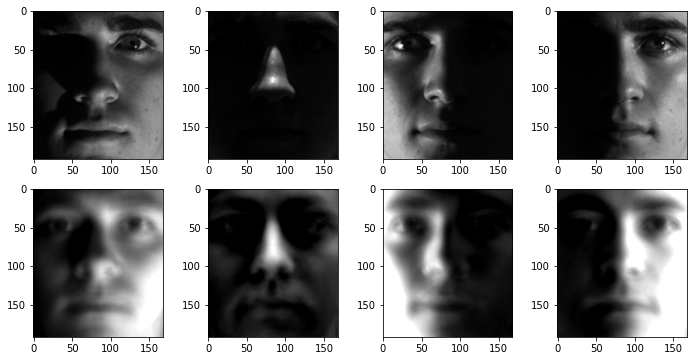

In [71]:
A_approx = U_trunc @ S_trunc @ Vh_trunc
appr_data = [np.reshape(np.minimum(np.maximum(A_approx[i,:],0),127),data[0].shape) for i in range(len(data))]
appr_images = [Image.fromarray(d.astype(np.uint8)) for d in appr_data]
fig,axs = plt.subplots(2,4,figsize=(12,6))
axs[0,0].imshow(data[0],cmap="gray")
axs[0,1].imshow(data[1],cmap="gray")
axs[0,2].imshow(data[2],cmap="gray")
axs[0,3].imshow(data[3],cmap="gray")
axs[1,0].imshow(appr_images[0],cmap="gray")
axs[1,1].imshow(appr_images[1],cmap="gray")
axs[1,2].imshow(appr_images[2],cmap="gray")
axs[1,3].imshow(appr_images[3],cmap="gray")
plt.show()

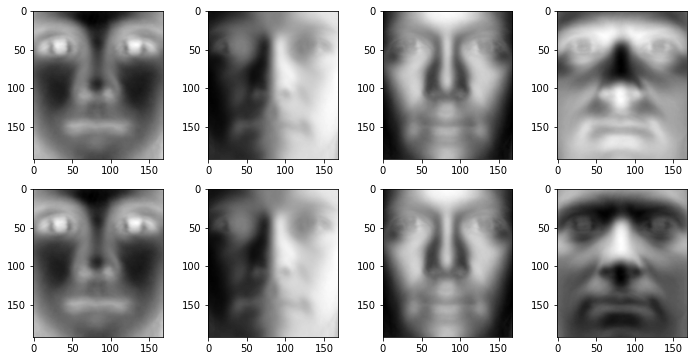

In [72]:
rand_basis = [np.reshape(127*(Vh1[i,:]-np.min(Vh1[i,:]))/(np.max(Vh1[i,:])-np.min(Vh1[i,:])),data[0].shape) for i in range(Vh1.shape[0])]
true_basis = [np.reshape(127*(Vh[i,:]-np.min(Vh[i,:]))/(np.max(Vh[i,:])-np.min(Vh[i,:])),data[0].shape) for i in range(Vh.shape[0])]
rand_images = [Image.fromarray(d.astype(np.uint8)) for d in rand_basis]
true_images = [Image.fromarray(d.astype(np.uint8)) for d in true_basis]
fig,axs = plt.subplots(2,4,figsize=(12,6))
axs[0,0].imshow(rand_images[0],cmap="gray")
axs[0,1].imshow(rand_images[1],cmap="gray")
axs[0,2].imshow(rand_images[2],cmap="gray")
axs[0,3].imshow(rand_images[3],cmap="gray")
axs[1,0].imshow(true_images[0],cmap="gray")
axs[1,1].imshow(true_images[1],cmap="gray")
axs[1,2].imshow(true_images[2],cmap="gray")
axs[1,3].imshow(true_images[3],cmap="gray")
plt.show()